# Plotting Script for showing grid of Color-MEIs as well as activations

In [11]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["display.limit"] = 50
dj.config["enable_python_native_blobs"] = True
dj.config['schema_name'] = "nnfabrik_color_mei"
schema = dj.schema("nnfabrik_color_mei")

from matplotlib import pyplot as plt
from torch import load

from nnfabrik.main import *

import nnfabrik
from collections import namedtuple
from nnfabrik import main, builder
import os
from os import listdir
from os.path import isfile, join
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlutils.measures import corr

from mlutils.data.datasets import StaticImageSet, FileTreeDataset
from nndichromacy.tables.from_nnfabrik import TrainedModel, DataInfo
from dataport.bcm.static import PreprocessedMouseData
from nnvision.utility.measures import get_explainable_var

from nndichromacy.tables.from_mei import MEI, TrainedEnsembleModel, MEISelector, MEIMethod, MEISeed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Select a dataset and method hash. If there is more than one ensemble for that dataset, chose an ensemble_hash instead.

In [2]:
mei_key = dict(method_hash='e203277aa2540dd9f907344ed5babb21', dataset_hash='68db788514e66723ffb230875164d577')

In [3]:
# numbe of MEIs

len(MEI&mei_key)

1074

In [4]:
# get table with the unit scores
from nndichromacy.tables.scores import CorrelationToAverge

In [59]:
# fetch the meis and outputs
mei_paths, output_paths = (MEI() * CorrelationToAverge.Units() & mei_key).fetch("mei", "output", limit=100, order_by='unit_avg_correlation DESC')

In [53]:
MEIs = np.stack([torch.load(path).detach().cpu().numpy().squeeze() for path in mei_paths])
evaluations = np.stack([torch.load(path)['featurevis.objectives.EvaluationObjective']["values"] for path in output_paths])
t_evaluations = np.stack([torch.load(path)['featurevis.objectives.EvaluationObjective']["times"] for path in output_paths])

# Plot Activations

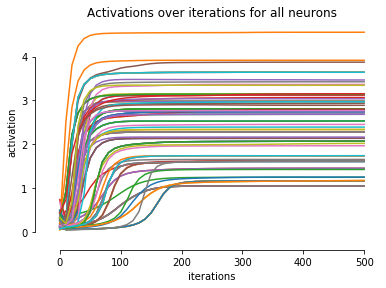

In [16]:
plt.plot(t_evaluations.T, evaluations.T)
sns.despine(trim=True, offset=10)
plt.xlabel("iterations")
plt.ylabel("activation")
plt.title("Activations over iterations for all neurons");

# Plot MEIs

### 1) G/B side-by-side

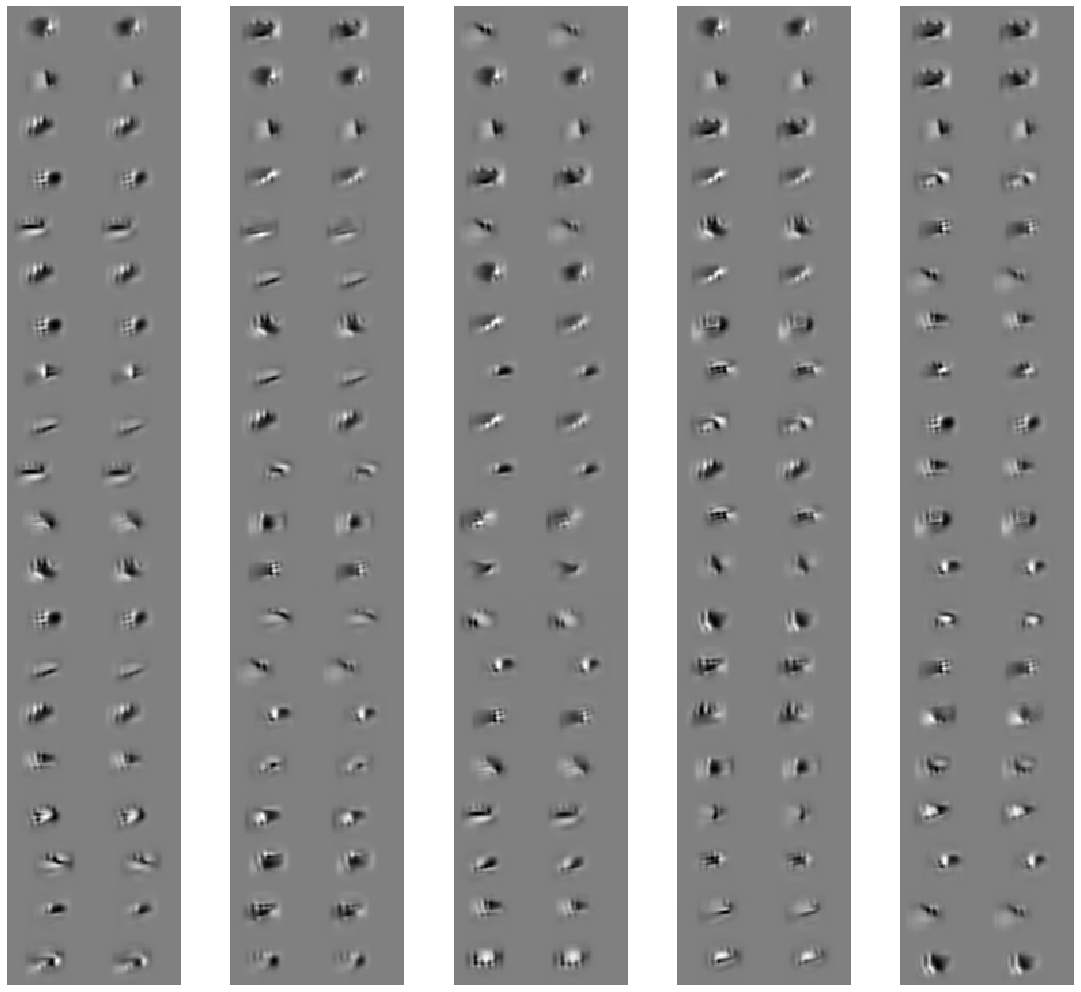

In [63]:
fig, axs = plt.subplots(20,5, figsize=(20,18))
plt.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(axs.ravel()):
    
    mei = np.hstack([MEIs[i][0],MEIs[i][1]])
    vmax = np.max(np.abs(mei))
    ax.imshow(mei, vmax = vmax, vmin=-vmax, cmap="gray")
    ax.axis("off")
plt.savefig("MEI_grid_B_G_23555-58-2.png", dpi=100, bbox_inches='tight')

### 2) RGB MEI

In [38]:
MEIs[0].shape

(2, 36, 64)

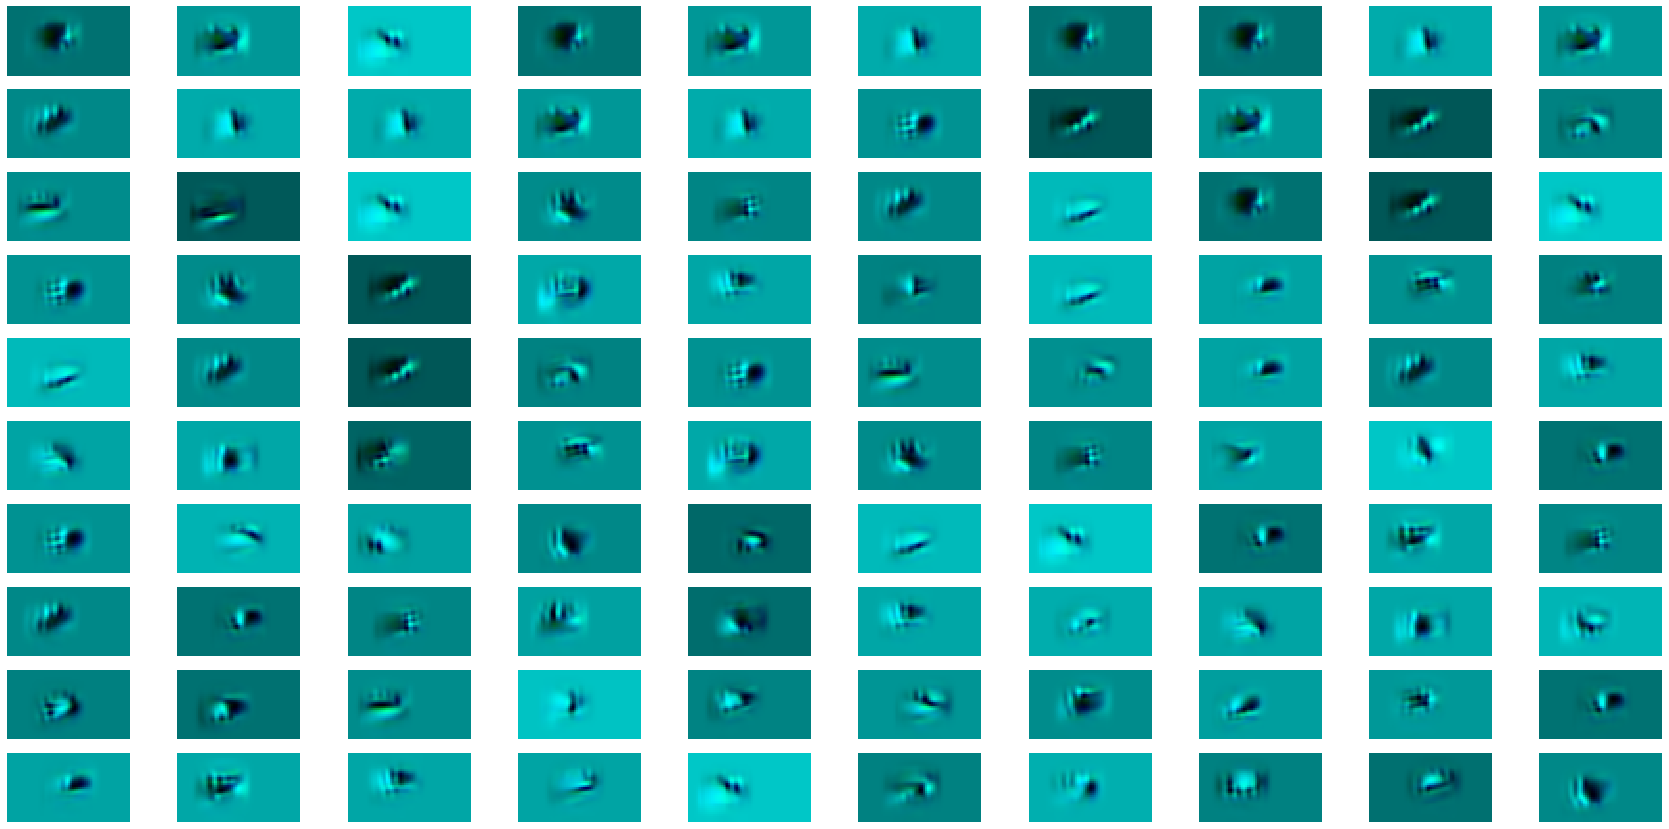

In [65]:
from nndichromacy.utility.measures import normalize_RGB
red_channel = np.zeros((1, *MEIs[0].shape[1:]))

fig, axs = plt.subplots(10,10, figsize=(30,15))
for i, ax in enumerate(axs.ravel()):
    
    # sets range of MEI to (0,1) for plotting
    mei = normalize_RGB(MEIs[i])
    rgb_mei = np.concatenate([red_channel, mei],axis=0)
    
    # swap axis, color has to be in the last dimension for plt.imshow
    rgb_mei =np.transpose(rgb_mei, (1, 2, 0))
    vmax = np.max(np.abs(rgb_mei))
    
    ax.imshow(rgb_mei, vmin=-vmax, vmax=vmax)
    ax.axis("off")
plt.savefig("MEI_grid_RGB_23555-58-2.pdf", dpi=100, bbox_inches='tight')

# Cleanup: Remove the fetched mei files

In [61]:
for i, path in enumerate(mei_paths):
    if os.path.exists(os.path.join(os.getcwd(), path)):
        os.remove(os.path.join(os.getcwd(), path))
        
for i, path in enumerate(output_paths):
    if os.path.exists(os.path.join(os.getcwd(), path)):
        os.remove(os.path.join(os.getcwd(), path))